# Création d'un scatter plot interactif

#### Visualisation des abondances et Pathway pour chaque protéine

Nous allons représenter la relation entre l'abondance des protéines (**Log2 Corrected Abundance Ratio**)  et la précision de la mesure (**LOG10 Adj.P-val**). 


In [3]:
import sys

#rootDir = "//ifb/data/mydatalocal"
rootDir = "/Users/guillaumelaunay/work/communications/lectures/UCBL/M2_bioinfo/VDB/TP"

projectDir = rootDir + "/VDB_jupyter"
libDir = projectDir + "/lib"
#dataDir= "/ifb/data/public/teachdata/m2binf_ucbl/data" 

dataDir = rootDir + "/data"


sys.path.append(libDir)

In [4]:
import pandas, uniprot, go
import numpy as np
from stat_utils import computeORA_BKG
# We use notebook backend to have interactivity support
%matplotlib notebook 

import matplotlib.pyplot as plt

#### Exemple pour commencer
Observer la cellule suivante qui illustre la construction d'un scatter plot et des améliorations possibles.

###### Creation du scatter plot
[matplotlib.axes.Axes.scatter()](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.scatter.html) permet d'intialiser le graphique.
###### Modification continue du scatter plot
Mais cette fonction retourne aussi un objet [PathCollection](https://matplotlib.org/3.1.1/api/collections_api.html) qui permet de modifier à posteriori le rendu des points du scatter plot.
###### Interactivité
L'affichage d'une figure via la méthode `fig.canvas.mpl_connect('EVENT_NAME', callbackFunction)` permet d'associer à [un évenement sur la figure](https://matplotlib.org/3.1.1/users/event_handling.html) l'execution du fonction (*callbackFunction*)

###### Illustration ci-dessous

<IPython.core.display.Javascript object>


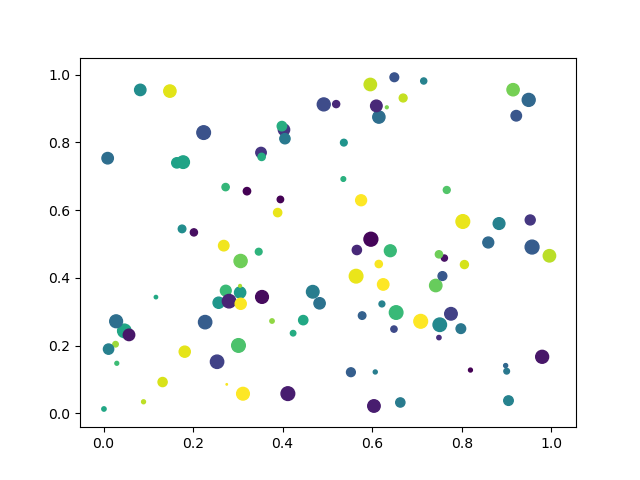

In [3]:
x, y, c, s = np.random.rand(4, 100)

def onclick(event):
    tx = 'button=%d, x=%d, y=%d, xdata=%f, ydata=%f' % (event.button, event.x, event.y, event.xdata, event.ydata)
    text.set_text(tx)
    col.set_sizes( np.random.rand(100) * 100 )
    
def onpick(event):
    ind = event.ind
    tx = str(ind)
    text.set_text(tx)
    col.set_sizes( np.random.rand(100) * 100 )
    col.set_color( np.full(100, 'tab:gray') )
    
fig = plt.figure()
ax1 = fig.add_subplot(111)
col = ax1.scatter(x, y, 100*s, c, picker=True)
text = ax1.text(0.5,1.1, "", va="bottom", ha="left")

#cid = fig.canvas.mpl_connect('button_press_event', onclick)
cid = fig.canvas.mpl_connect('pick_event', onpick)

## Volcano Plot simple
Ce type de figure représente pour chaque protéine en abscisse le taux d'abondance et en ordonnées la précision de la mesure.
Réaliser les graphiques suivants.
![caption](../figs/volcano_simple.png)

#### Lecture des données, `TSV`
* Liste des ratios d'abondance 
* Liste des pValue experimentales

In [4]:
import pandas
df=pandas.read_csv(projectDir + "/TCL_wt1.tsv", delimiter ="\t")

dfClean = df[ (df['Log2 Corrected Abundance Ratio'] != '#VALEUR!') & (df['LOG10 Adj.P-val'] != '#VALEUR!')]
dfClean = dfClean.copy()
dfClean.loc[:,'Log2 Corrected Abundance Ratio'] = dfClean.loc[:,'Log2 Corrected Abundance Ratio'].astype(float)
dfClean.loc[:,'LOG10 Adj.P-val'] = dfClean.loc[:,'LOG10 Adj.P-val'].astype(float)


saList = dfClean[ dfClean['Log2 Corrected Abundance Ratio'] > 0.0 ]['Accession'].tolist()
abundance = dfClean[ : ]['Log2 Corrected Abundance Ratio'].tolist()
allList = dfClean[ : ]['Accession'].tolist()
pvalue = dfClean[ : ]['LOG10 Adj.P-val'].tolist()

<IPython.core.display.Javascript object>


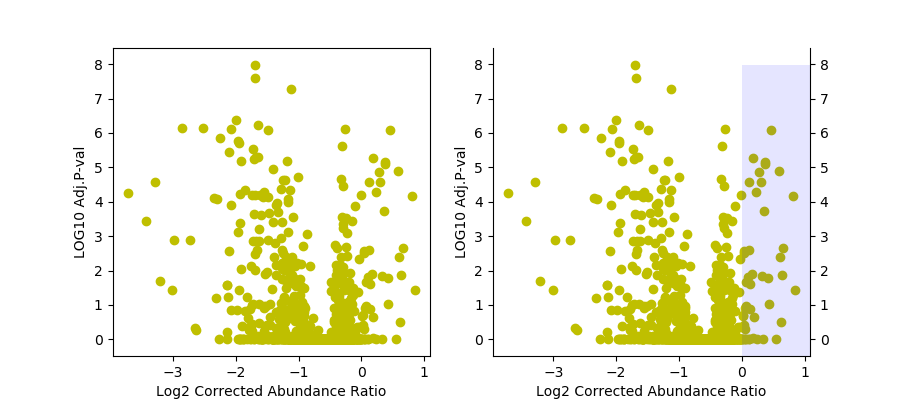

In [5]:
from matplotlib.patches import Rectangle
x = [ float(i) for i in dfClean['Log2 Corrected Abundance Ratio'].tolist() ]
y = [ float(i) for i in dfClean['LOG10 Adj.P-val'].tolist() ]
labels = dfClean['Accession'].tolist()


def drawScatter(x, y, ax=None, fig=None):
    ax.set_yticks(np.arange(min(y), max(y)+1, 1.0))
    scat = ax.scatter(x, y, color='y', picker=5)
    ax.set_ylabel('LOG10 Adj.P-val')
    ax.set_xlabel('Log2 Corrected Abundance Ratio')
    return scat, fig, ax
  

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(9,4)
drawScatter(x,y, axes[0])
drawScatter(x,y, axes[1])

axes[1].spines['top'].set_visible(False)
axes[1].tick_params(labelright=True, right=True)

x_min, x_max = axes[1].get_xlim()
y_min, y_max = axes[1].get_ylim()
tau = 0.0
p = Rectangle([tau, y_min], x_max, y_max, facecolor='blue', alpha=0.1)
r=axes[1].add_patch(p)

### 3a Volcano plot interactif

##### Lecture des données additionelles **`TSV`**

* Liste des noms des protéines

##### Dessiner un volcano plot qui affichera le nom de la protéine clickée

<IPython.core.display.Javascript object>


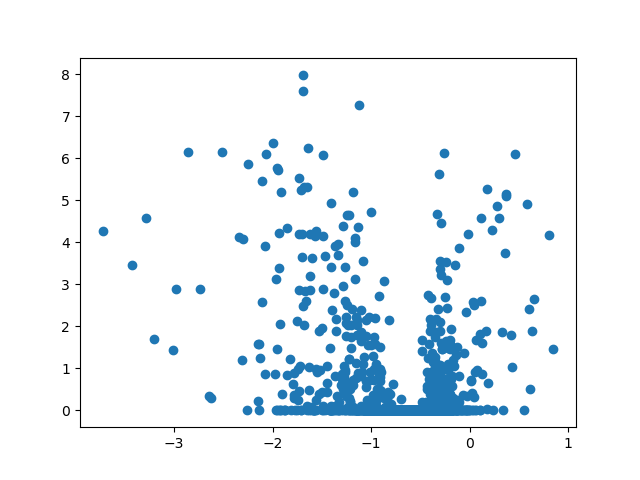

In [6]:
x,y, labels = (abundance, pvalue, allList)
def onpick(event):
    ind = event.ind
    tx = str(ind)
    msg = '\n'.join([ str(labels[i]) for i in ind ])
    text.set_text(msg)
    #print('onpick3 scatter:', ind, np.take(x, ind), np.take(y, ind))
 
fig = plt.figure()
ax1 = fig.add_subplot(111)
col = ax1.scatter(x, y, picker=True)

text = ax1.text(0, 7.5, "", va="bottom", ha="left")

cid = fig.canvas.mpl_connect('pick_event', onpick)

### 3b Intégration des annotations GO
#### Lectures des données additionelles
     
* Chargement des données de *OverRepresentationAnalysis*, à partir du fichier **`JSON`** du [TP2](TP2_solustions.ipynb)

* Rappel sur le format du fichier


```json
    { 
        "plasma membrane" : {
            "name" : "plasma membrane",
            "pvalue" : 0.9999980015962491,
            "proteineTotal" : [uniprotID, ..],
            "proteineSA" : [uniprotID, ..]
    
           },
       ....
     }
```

Un document JSON valide est obligatoirement un dictionnaire. Pensez, après lecture du fichier, à trier les pathways par **pvalue croissante**.

In [1]:
import json

data = {}
with open ("TP_ORA.json", 'r') as fp:
    data = json.load(fp)

pathways = sorted([ d for k,d in data.items() ], key=lambda x:x['pvalue'])
#pathways

### Fontionalités à implémenter au choix

* Colorier les protéines des n Pathways les plus représentés dans le namespace GO de votre choix (biological_process, molecular function, cellular component): **utiliser des palettes de couleurs catégorielles**. Priorité sera donnée au pathway avec le meilleur score ORA.
* Dessiner un volcano plot qui coloriera d'une même couleur les protéines appartenant au pathway GO de la protéine clickée
* Dessiner un volcano plot qui fera disparaitre les protéines n'appartenant pas au même pathway(s) GO que ceux de la protéine clickée

### Palettes de couleurs
matplotlib propose une variété de [palettes de couleurs](https://matplotlib.org/3.1.1/tutorials/colors/colormaps.html).
##### Divergentes ou Séquentielles
![caption](../figs/cmap1.png)
![caption](../figs/cmap2.png)
##### Continues ou Catégorielles
![caption](../figs/cmap4.png)
##### Cyclique
![caption](../figs/cmap3.png)
##### Quel type de palette choisir pour colorier en fonction:
* Des pathways ?
* Des pvalues ? 

### API colormap
###### Charger une palette de couleurs
```python
cmap = plt.get_cmap('Paired')
```

###### Palettes de couleurs catégorielles
Elles proposent des valeurs discrètes organisées en une liste de triplets RGB
###### Connaitre son nombre d'éléments
```python
print(cmap.N)
```
###### Accéder à sa liste de couleurs
```python
print(cmap.colors)
```
###### Exemple
![caption](../figs/cmap5.png)

##### Palettes de couleurs quantitatives
Elles proposent des valeurs de couleurs continues.

Il s'agit de fonctions prenant une valeur en entrée et retournant un triplet RGB. Par défault le domaine de cette fonction est $[0, 1]$. L'intervalle est "cyclique", (1.2 donne 0.2, -1.5 donne 0.5, etc).

Dans la pratique on devra donc normaliser les valeurs à colorer, pour qu'elles soient contenues dans l'intervalle $[0, 1]$. Deux questions se posent alors pour définir cette fonction $f$:
* Les bornes min et max de l'intervalle des valeurs à colorer, telles que $f(min) = 0, f(max) = 1$
* L'interpolation pour determiner les valeurs intermédiaires, les plus usuelles étant:
    * Linéaire
    * Logarithmique
    
**Le module [colors](https://matplotlib.org/3.1.1/api/colors_api.html) fournit deux outils suivants**

###### Fonctions de normalisation 
![caption](../figs/cmap6.png)
###### Fonctions de couleur
![caption](../figs/cmap7.png)

###### Exemples avec la palette HSV
* Colorations avec **normalisation linéaire**, **normalisation logarithmique**, **normalisation logarithmique explicite**
![caption](../figs/cmap8.png)

## Exemple de figure à construire

* Scatter plot dans le subplot de gauche
* Légende et affichage du nom des protéines clickées dans le subplot de droite

![caption](../figs/lgd.png)

<IPython.core.display.Javascript object>


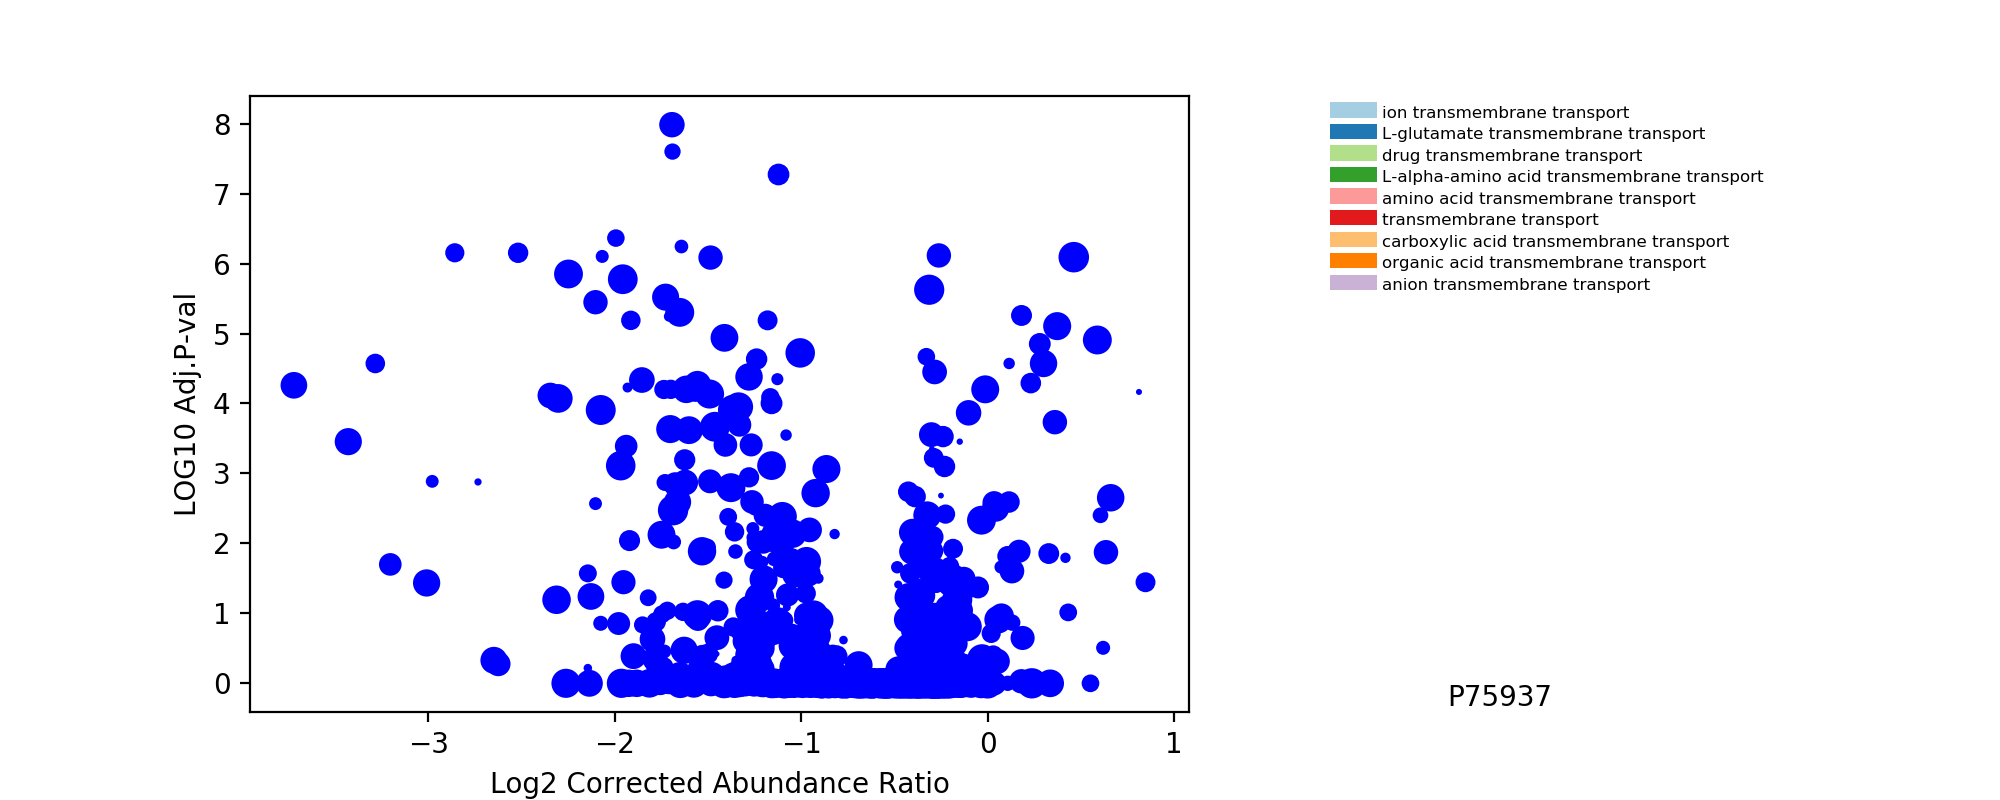

(0.0, 1.0, 0.0, 1.0)

In [10]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle



def colorByPathway(pathways, labels, cmap):
    colors = [ 'tab:gray' for n in labels ]
    
    for iPath, pathway in enumerate(reversed(pathways)):
        for protein in pathway['proteineTotal']:
                iProt = labels.index(protein)              
                colors[iProt] = cmap.colors[iPath]
                
    return colors

def createLegend(ax, pathways, cmap):
    
    rectHeight = 0.025
    rectWidth = 0.1
    legendSpacing = 0.01
    x = ax.get_xlim()
    y = ax.get_ylim()
    _x = x[0]
    _y = y[1]

    legendBoxes = []
    for i, p in enumerate(pathways[:cmap.N]):
        _y -= rectHeight + legendSpacing
        rect = Rectangle((_x, _y), rectWidth, rectHeight)
        legendBoxes.append(rect)
        ax.text(_x + rectWidth + 0.01, _y, p['name'], fontsize=6)
    pc = PatchCollection(legendBoxes, facecolor=cmap.colors)
    ax.add_collection(pc)

    ax.margins
    return legendBoxes

def proteinListText(pathway):
    return  '\n'.join(pathway["proteineTotal"])

def getPathway(data, pathwayName = None, proteinName=None):
    res = []
    for d in data:
        if pathwayName : 
            if d['name'] == pathwayName:
                return [d]
        if proteinName : 
            if proteinName in d['proteineTotal']:
                res.append(d)
    if not res:
        raise ValueError("No pathway found")
    return res

def onpickUpdate(event):
    ind = event.ind
    tx = str(ind)
    msg = '\n'.join([ str(labels[i]) for i in ind ])
    text.set_text(msg)
    col.set_color(['b' for x in allList])
    col.set_sizes( np.random.rand(len(allList)) * 100 )

    
x,y, labels = (abundance, pvalue, allList)

cmap = plt.get_cmap('Paired')
color_node = colorByPathway(pathways[:cmap.N], labels, cmap)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4),gridspec_kw={'width_ratios': [3, 1.5]})
col = ax1.scatter(x, y, c=color_node, picker=True)

ax1.set_ylabel('LOG10 Adj.P-val')
ax1.set_xlabel('Log2 Corrected Abundance Ratio')
    
text = ax2.text(0.25, 0., "", va="bottom", ha="left")
cid = fig.canvas.mpl_connect('pick_event', onpickUpdate)

createLegendBoxes = createLegend(ax2, pathways, cmap ) 
ax2.axis('off')